<h2 align="center">Основи побудови лінійних моделей за допомогою Scikit-Learn</h2>

- Вступ
- Набір даних
- Завантаження даних та імпорт необхідних бібліотек
- Збір і підготовка даних
- Дослідницький аналіз даних
- Створення простої лінійної регресії
- Модель множинної лінійної регресії

Набір даниx Boston Housing Dataset містить наступні характеристики:
- CRIM: рівень злочинності
- ZN: частка житлової землі
- INDUS: частка промислових земель
- CHAS: межує з річкою (1) чи ні (0)
- NOX: концентрація оксидів азоту
- RM: середня кількість кімнат
- AGE: частка будівель до 1940 року
- DIS: відстань до центрів зайнятості
- RAD: доступність до радіальних магістралей
- TAX: ставка податку на нерухомість
- PTRATIO: співвідношення учнів до вчителів
- B: частка афроамериканського населення
- LSTAT: % населення з низьким статусом
- MEDV: медіанна вартість житла в $1000

In [43]:
# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from yellowbrick.regressor import PredictionError
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)

In [44]:
# Завантаження даних
df = pd.read_csv('Boston.csv')
print("Initial shape:", df.shape)
df.head()

Initial shape: (506, 15)


,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Обробка викидів та підготовка даних

In [45]:
def remove_outliers(df, n_sigmas=3):
    """
    Видаляє викиди, які знаходяться за межами n стандартних відхилень від середнього
    """
    df_clean = df.copy()
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            mean = df[column].mean()
            sd = df[column].std()
            df_clean = df_clean[(df_clean[column] <= mean + (n_sigmas * sd)) & 
                               (df_clean[column] >= mean - (n_sigmas * sd))]
    return df_clean

# Видалення викидів
df_clean = remove_outliers(df)
print("Shape before removing outliers:", df.shape)
print("Shape after removing outliers:", df_clean.shape)

# Розділення на features та target
X = df_clean.drop('medv', axis=1)
y = df_clean['medv']

# Створення поліноміальних ознак
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Відбір ознак на основі кореляції
def select_features(X, y, correlation_threshold=0.1):
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    })
    scores = scores.sort_values('Score', ascending=False)
    selected_features = scores[scores['Score'] > correlation_threshold]['Feature']
    return X[selected_features], selected_features

X_selected, selected_features = select_features(X_poly_df, y)
print("\nNumber of selected features:", len(selected_features))

# Нормалізація даних
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled = pd.DataFrame(X_scaled, columns=selected_features)

Shape before removing outliers: (506, 15)
Shape after removing outliers: (415, 15)

Number of selected features: 104


## Дослідницький аналіз даних

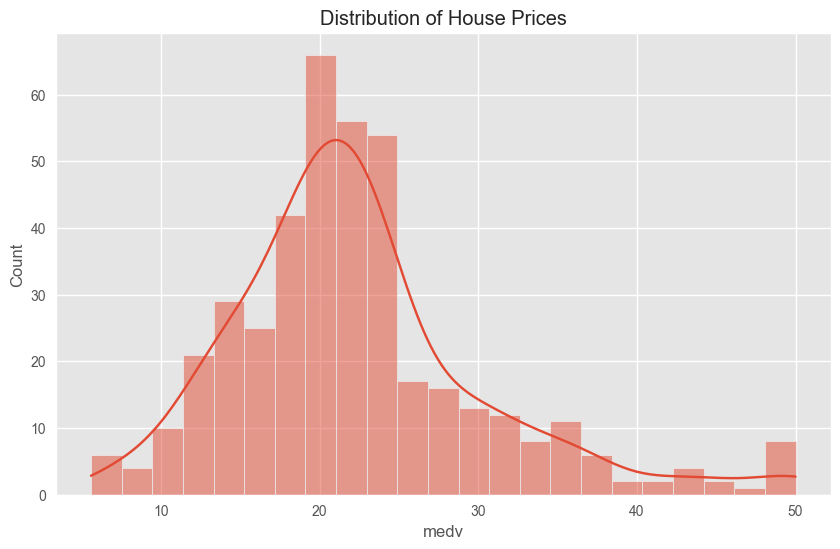

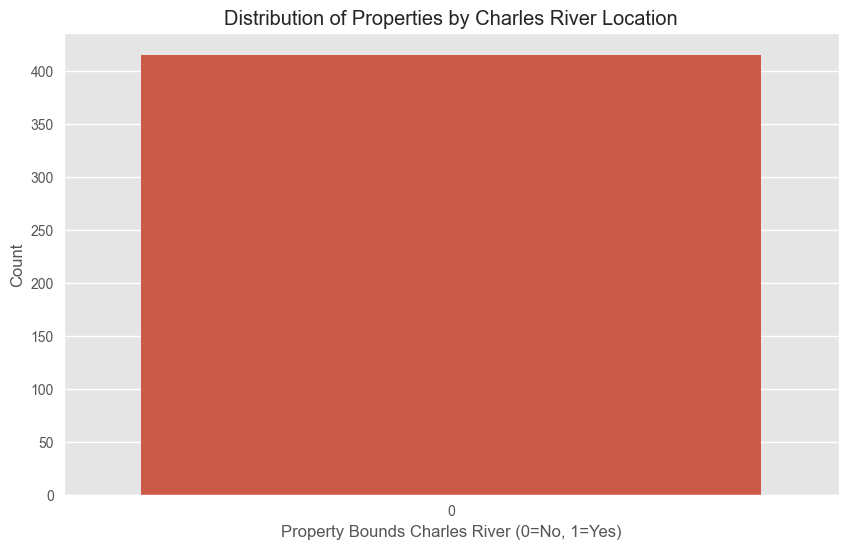

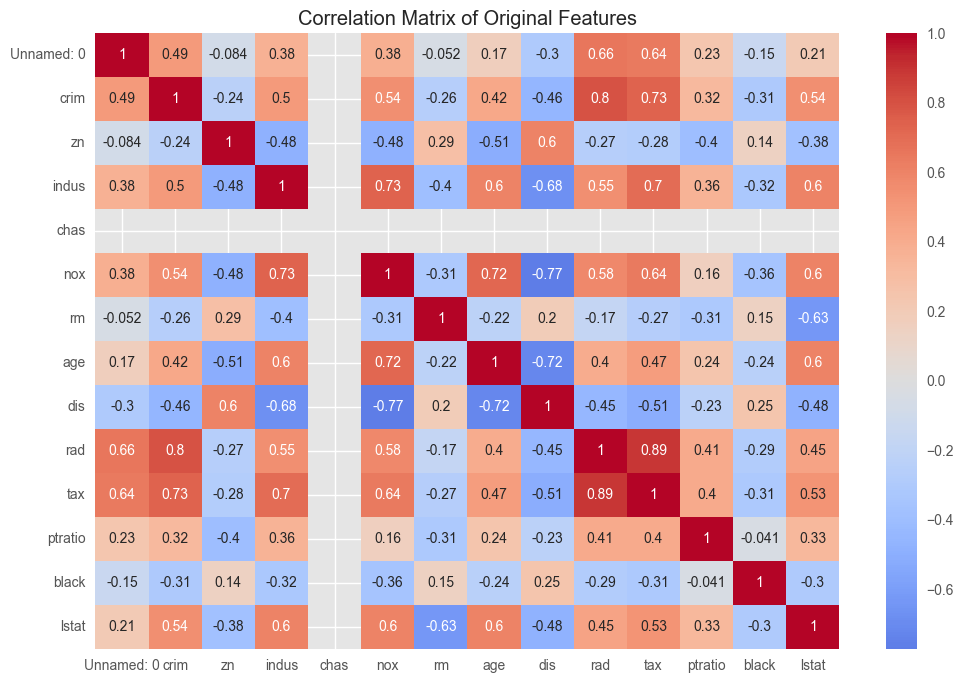

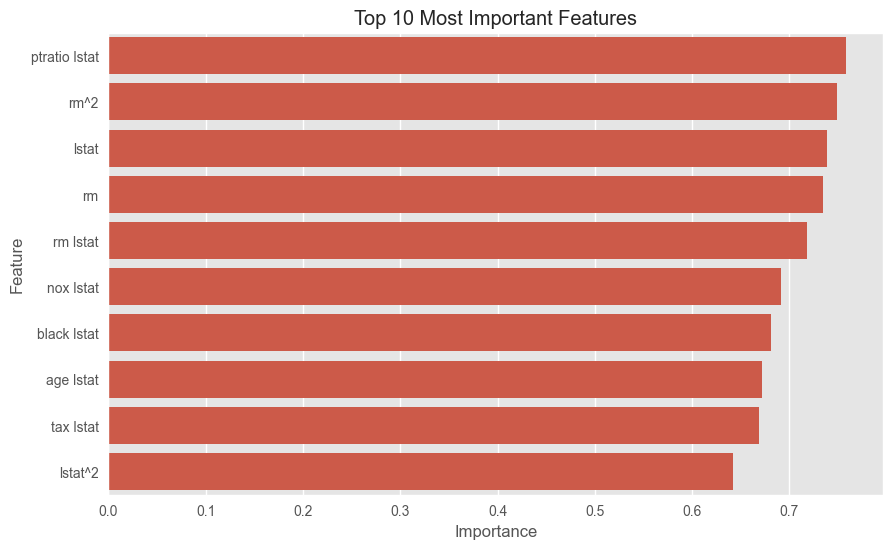


Shape after removing 'chas': (415, 13)


In [46]:
# Візуалізація розподілу цільової змінної
plt.figure(figsize=(10, 6))
sns.histplot(data=y, kde=True)
plt.title('Distribution of House Prices')
plt.show()

# Візуалізація розподілу змінної chas (Charles River dummy variable)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='chas')
plt.title('Distribution of Properties by Charles River Location')
plt.xlabel('Property Bounds Charles River (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()


# Кореляційна матриця для оригінальних ознак
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Original Features')
plt.show()

# Top 10 найважливіших ознак
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': np.abs(np.corrcoef(X_scaled.T, y)[:-1, -1])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Top 10 Most Important Features')
plt.show()

# Видалення змінної chas з набору даних
X = X.drop('chas', axis=1)
print("\nShape after removing 'chas':", X.shape)


## Створення та оцінка моделей

Simple Linear Regression Results:
R2 score: 0.5660
RMSE: 4.5375

Multiple Linear Regression Results:
R2 score: 0.8450
RMSE: 2.7118


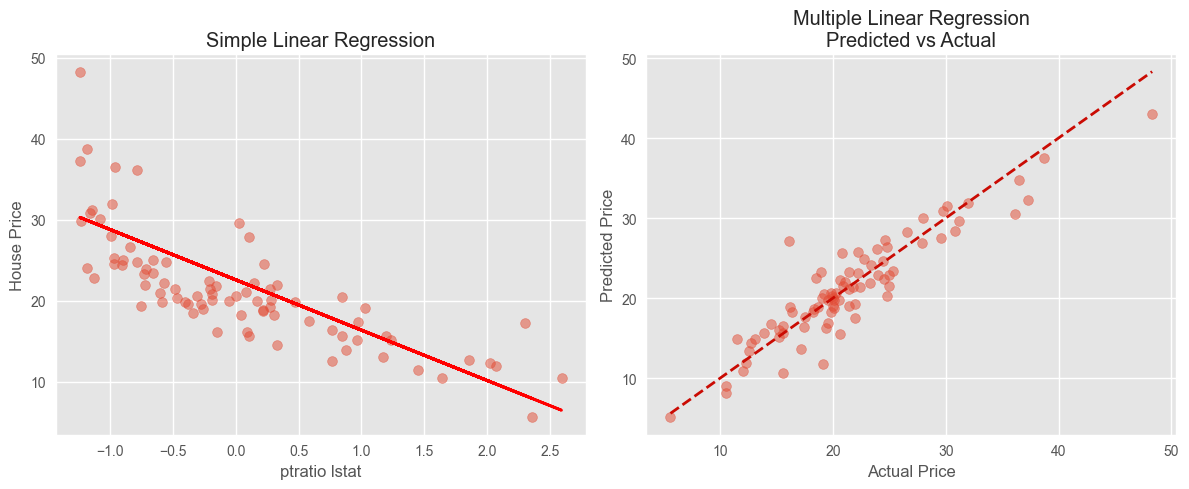

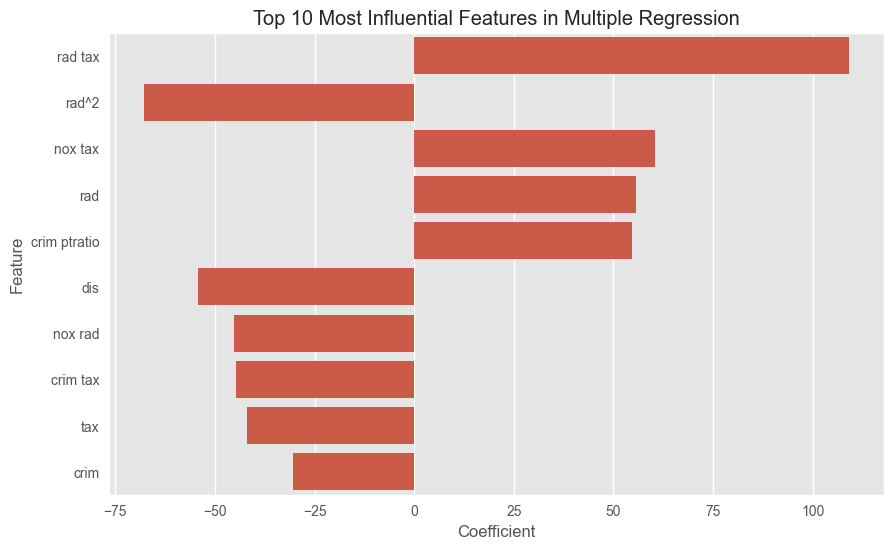

In [47]:
# Розділення даних на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Проста лінійна регресія (використовуємо найважливішу ознаку)
top_feature = feature_importance.iloc[0]['Feature']
model_simple = LinearRegression()
model_simple.fit(X_train[[top_feature]], y_train)
y_pred_simple = model_simple.predict(X_test[[top_feature]])

print("Simple Linear Regression Results:")
print(f"R2 score: {r2_score(y_test, y_pred_simple):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_simple)):.4f}\n")

# Множинна лінійна регресія
model_multi = LinearRegression()
model_multi.fit(X_train, y_train)
y_pred_multi = model_multi.predict(X_test)

print("Multiple Linear Regression Results:")
print(f"R2 score: {r2_score(y_test, y_pred_multi):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_multi)):.4f}")

# Візуалізація результатів
plt.figure(figsize=(12, 5))

# Проста регресія
plt.subplot(1, 2, 1)
plt.scatter(X_test[top_feature], y_test, alpha=0.5)
plt.plot(X_test[top_feature], y_pred_simple, color='red', linewidth=2)
plt.title('Simple Linear Regression')
plt.xlabel(top_feature)
plt.ylabel('House Price')

# Множинна регресія
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_multi, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Multiple Linear Regression\nPredicted vs Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.tight_layout()
plt.show()

# Аналіз коефіцієнтів множинної регресії
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model_multi.coef_
})
coefficients = coefficients.sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients.head(10), x='Coefficient', y='Feature')
plt.title('Top 10 Most Influential Features in Multiple Regression')
plt.show()

In [48]:
# Add these improvements after the existing code

# 1. Feature Engineering - Create polynomial features and interaction terms
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
feature_names = poly.get_feature_names_out(X.columns)

# Train model with polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)

print("\nPolynomial Regression Results:")
print(f"R2 score: {r2_score(y_test, y_pred_poly):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_poly)):.4f}")

# 2. Cross-validation to assess model stability
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_multi, X_scaled, y, cv=5, scoring='r2')
print("\nCross-validation scores:")
print(f"R2 scores: {cv_scores}")
print(f"Mean R2: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 3. Ridge Regression (L2 regularization)
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("\nRidge Regression Results:")
print(f"R2 score: {r2_score(y_test, y_pred_ridge):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.4f}")

# 4. Lasso Regression (L1 regularization)
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("\nLasso Regression Results:")
print(f"R2 score: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.4f}")

# 5. Elastic Net (Combination of L1 and L2)
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic.fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)

print("\nElastic Net Results:")
print(f"R2 score: {r2_score(y_test, y_pred_elastic):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_elastic)):.4f}")

# Visualize results comparison
models = ['Linear', 'Polynomial', 'Ridge', 'Lasso', 'Elastic Net']
r2_scores = [
    r2_score(y_test, y_pred_multi),
    r2_score(y_test, y_pred_poly),
    r2_score(y_test, y_pred_ridge),
    r2_score(y_test, y_pred_lasso),
    r2_score(y_test, y_pred_elastic)
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=r2_scores)
plt.title('Model Comparison - R² Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance comparison across different models
def get_feature_importance(model, features):
    return pd.DataFrame({
        'Feature': features,
        'Coefficient': np.abs(model.coef_)
    }).sort_values('Coefficient', ascending=False)

# Compare feature importance across models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Feature Importance Comparison Across Models')

# Linear
importance_linear = get_feature_importance(model_multi, X.columns)
sns.barplot(data=importance_linear.head(10), x='Coefficient', y='Feature', ax=axes[0,0])
axes[0,0].set_title('Linear Regression')

# Ridge
importance_ridge = get_feature_importance(ridge, X.columns)
sns.barplot(data=importance_ridge.head(10), x='Coefficient', y='Feature', ax=axes[0,1])
axes[0,1].set_title('Ridge Regression')

# Lasso
importance_lasso = get_feature_importance(lasso, X.columns)
sns.barplot(data=importance_lasso.head(10), x='Coefficient', y='Feature', ax=axes[1,0])
axes[1,0].set_title('Lasso Regression')

# Elastic Net
importance_elastic = get_feature_importance(elastic, X.columns)
sns.barplot(data=importance_elastic.head(10), x='Coefficient', y='Feature', ax=axes[1,1])
axes[1,1].set_title('Elastic Net')

plt.tight_layout()
plt.show()

# Learning curves to diagnose bias-variance tradeoff
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_scaled, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.plot(train_sizes, train_mean, label="Training score")
    plt.plot(train_sizes, test_mean, label="Cross-validation score")
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    
    plt.grid()
    plt.legend(loc="best")
    plt.show()

# Plot learning curves for different models
plot_learning_curve(model_multi, "Learning Curve - Linear Regression")
plot_learning_curve(ridge, "Learning Curve - Ridge Regression")
plot_learning_curve(lasso, "Learning Curve - Lasso Regression")
plot_learning_curve(elastic, "Learning Curve - Elastic Net")

ValueError: input_features is not equal to feature_names_in_